In [3]:
import sys
import os
sys.path.append('../src')

In [5]:
import random
from tqdm import tqdm


import numpy as np
import pandas as pd


import global_var
import augment
import dataset
import modeling


import cv2
import torch
from torch.utils.data import DataLoader
from torchvision import models as models
import torch.nn as nn
import torch.optim as optim


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=256)

# Load data

In [4]:
train_cl_nm = pd.read_csv('train.csv')
test_nm = pd.read_csv('test.csv')
test_extended_nm = pd.read_csv('test_extended.csv')

In [5]:
X_train, y_train = [], []

In [6]:
for index, row in tqdm(train_cl_nm.iterrows()):
    im = cv2.imread(global_var.TRAIN_DIR + row['filename'] + '.png')
    X_train.append(im)
    y_train.append(row['sign'])

31080it [01:40, 310.11it/s]


In [7]:
X = np.array(X_train)
y = np.array(y_train).reshape(-1,1)

In [8]:
test = []
for index, row in tqdm(test_nm.iterrows()):
    im = cv2.imread(global_var.TEST_DIR + row['filename'] + '.png')
    test.append(im)

1000it [00:03, 302.57it/s]


In [9]:
test_extended = []
for index, row in tqdm(test_extended_nm.iterrows()):
    if row['filename'] in test_nm.filename.values:
        im = cv2.imread(global_var.TEST_DIR + row['filename'] + '.png')
    else:
        im = cv2.imread(global_var.TEST_EXT_DIR + row['filename'] + '.jpeg')
    test_extended.append(im)

101000it [06:17, 267.74it/s]


In [10]:
X_test = np.array(test)
inference_data = dataset.Airplane_test(X_test, augmentation = augment.valid_augmentation(global_var.IMAGE_SIZE))
inference_dataloader = DataLoader(inference_data, batch_size=global_var.BATCH_SIZE, shuffle=False)

In [11]:
X_test_ext = np.array(test_extended)
inference_data = dataset.Airplane_test(X_test_ext, augmentation = augment.valid_augmentation(global_var.IMAGE_SIZE))
inference_ext_dataloader = DataLoader(inference_data, batch_size=global_var.BATCH_SIZE, shuffle=False)

# Training

In [12]:
# def train_model(model, device, loss_fn, optimizer, scheduler, train_loader, val_loader, num_epoch, DECAY, n_fold):
#     train_losses = []
#     test_losses = []
#     acc = []
#     f = []
#     roc = []
#     mean_score = []

#     for i in range(num_epoch):
#         print('Epoch №:', i)
#         epoch_train_losses = []
#         model.train(True)
#         for X_train, y_train in tqdm(train_loader):
#             # Посчитаем предсказание и лосс
#             X_train = X_train.to(device)
#             y_train = y_train.to(device)
#             y_pred = model(X_train)
#             loss = loss_fn(y_pred, y_train)
#             del y_pred

#             # зануляем градиент
#             optimizer.zero_grad()

#             # backward
#             loss.backward()

#             # ОБНОВЛЯЕМ веса
#             optimizer.step()
#             scheduler.step()

#             # Запишем число (не тензор) в наши батчевые лоссы
#             epoch_train_losses.append(loss.item())   
                    
#         train_losses.append(np.mean(epoch_train_losses))
        
#         # Теперь посчитаем лосс на вал
#         with torch.no_grad():
#             model.eval()
#             epoch_test_losses = []
#             epoch_acc = []
#             epoch_f = []
#             epoch_roc_score = []
#             epoch_mean = []
#             for X_val, y_val in val_loader:
#                 X_val, y_val = X_val.to(device), y_val.to(device)
#                 y_pred = model(X_val)
#                 loss = loss_fn(y_pred, y_val)
            
#                 epoch_test_losses.append(loss.item())
#                 y_pred = y_pred.tanh().detach().cpu().numpy()

#                 y_pred_rounded = (y_pred>=0.4).astype(int).reshape(-1)

#                 accuracy = accuracy_score(y_val.cpu(), y_pred_rounded)
#                 if 1 not in y_val.cpu() or 0 not in y_val.cpu():
#                     if 1 in y_val.cpu():
#                         y_val_new = np.array(list(y_val.cpu().numpy().reshape(-1)) + [0])
#                         y_pred_rounded_new = np.array(list(y_pred_rounded) + [0])
#                         y_pred_new = np.array(list(y_pred.reshape(-1)) + [0.000001])
#                     else:
#                         y_val_new = np.array(list(y_val.cpu().numpy().reshape(-1)) + [1])
#                         y_pred_rounded_new = np.array(list(y_pred_rounded) + [1])
#                         y_pred_new = np.array(list(y_pred.reshape(-1)) + [0.99999999])
                    
#                     f1 = f1_score(y_val_new, y_pred_rounded_new)
#                     roc_score = roc_auc_score(y_val_new, y_pred_new)
#                 else:
#                     f1 = f1_score(y_val.cpu(), y_pred_rounded)
#                     roc_score = roc_auc_score(y_val.cpu(), y_pred)

#                 epoch_acc.append(accuracy)
#                 epoch_f.append(f1)
#                 epoch_roc_score.append(roc_score)
#                 epoch_mean.append(roc_score*0.5+accuracy*0.3+f1*0.2)

#                 del y_pred

#             test_losses.append(np.mean(epoch_test_losses))
#             acc.append(np.mean(epoch_acc))
#             f.append(np.mean(epoch_f))
#             roc.append(np.mean(epoch_roc_score))
#             mean_score.append(np.mean(epoch_mean))
            
#             torch.save(model.state_dict(), f'epoch_{i}_fold_{n_fold}.pth')  # сохраняем веса эпох

#             print(
#                 'Train loss =', train_losses[-1],
#                 'Val loss =', test_losses[-1],
#                 f'Val scores: acc:{acc[-1]}, f1: {f[-1]}, roc: {roc[-1]}, mean: {mean_score[-1]}'
#             )
                
#     return train_losses, test_losses, acc, f, roc, mean_score

In [13]:
# kfold = StratifiedKFold(n_splits=7)

Fold 0


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.2596112135886861 Val loss = 0.14351086488791875 Val scores: acc:0.935450487012987, f1: 0.856084363640352, roc: 0.9856790390780655, mean: 0.9446915383709993
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11248445395005947 Val loss = 0.13880213765161378 Val scores: acc:0.9406858766233765, f1: 0.8715532138970311, roc: 0.988441698394662, mean: 0.9507372549637505
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.098538966885095 Val loss = 0.3626808651856014 Val scores: acc:0.866213474025974, f1: 0.6437593468484312, roc: 0.9831693958337938, mean: 0.8802006094943753
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.0877413853521695 Val loss = 0.07286939354879515 Val scores: acc:0.9710227272727272, f1: 0.9405933888978502, roc: 0.9953140321937503, mean: 0.9770825120582632
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.08074068778938653 Val loss = 0.0497933923133782 Val scores: acc:0.9846185064935065, f1: 0.9692736791041525, roc: 0.9986701712998403, mean: 0.9885753734188025
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.06385836218211925 Val loss = 0.03971512977566038 Val scores: acc:0.9878449675324676, f1: 0.9756556363858004, roc: 0.998773434052101, mean: 0.9908713345629507
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.05274774348942572 Val loss = 0.03269211681825774 Val scores: acc:0.9868506493506494, f1: 0.97390039516964, roc: 0.9990107361084185, mean: 0.9903406418933322
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.045243152711344395 Val loss = 0.024059720377304725 Val scores: acc:0.991984577922078, f1: 0.9839975485215271, roc: 0.9993367656386584, mean: 0.9940632659002581
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.03894866781273598 Val loss = 0.021350540819444826 Val scores: acc:0.9926542207792207, f1: 0.9853042241663638, roc: 0.9995604234888185, mean: 0.9946373228114483
Epoch №: 9


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


Train loss = 0.03494762853634628 Val loss = 0.020096619427204133 Val scores: acc:0.9942167207792207, f1: 0.9883516774567787, roc: 0.9995917105448145, mean: 0.9957312069975289


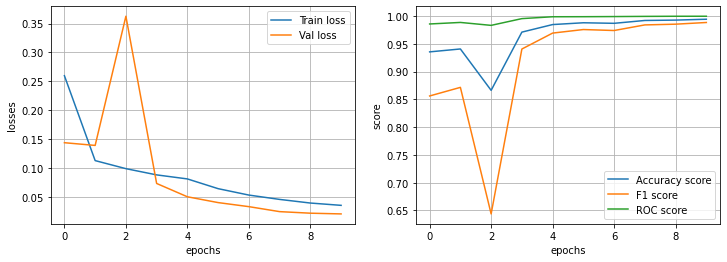

Fold 1


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.21949825836924844 Val loss = 0.12342017335551125 Val scores: acc:0.9586241883116884, f1: 0.9202769089820905, roc: 0.9920585197773071, mean: 0.9676718981785782
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11760100139456503 Val loss = 0.10112871038062232 Val scores: acc:0.9636363636363636, f1: 0.9234315316357343, roc: 0.9907880056569683, mean: 0.9691712182465401
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.10163148891840255 Val loss = 0.07541742069380623 Val scores: acc:0.966883116883117, f1: 0.930348813846978, roc: 0.9971142787735382, mean: 0.9746918372210996
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.08340019577641807 Val loss = 0.07792431174644403 Val scores: acc:0.975, f1: 0.951086977163277, roc: 0.9977640758831862, mean: 0.9815994333742485
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.0710270430393624 Val loss = 0.033417399094573086 Val scores: acc:0.9905235389610391, f1: 0.9805718411137375, roc: 0.9989370471483219, mean: 0.9927399534852199
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.06417838246093698 Val loss = 0.0412576078836407 Val scores: acc:0.9838271103896105, f1: 0.9667536625167938, roc: 0.9984700470846335, mean: 0.9877338891625586
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.054913487998349816 Val loss = 0.03053790155931243 Val scores: acc:0.9899553571428571, f1: 0.9792315038797744, roc: 0.9990297137450271, mean: 0.9923477647913257
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.04554043003941694 Val loss = 0.024693626265174577 Val scores: acc:0.9917410714285714, f1: 0.9821859139252951, roc: 0.9994850522745538, mean: 0.9937020303509072
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.036235637539489704 Val loss = 0.021632152712637825 Val scores: acc:0.9930803571428571, f1: 0.985184034323907, roc: 0.9995533297867396, mean: 0.9947375789010083
Epoch №: 9


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


Train loss = 0.034742931363007955 Val loss = 0.020380288355850748 Val scores: acc:0.9935267857142858, f1: 0.9860141086752208, roc: 0.9996078910054552, mean: 0.9950648029520575


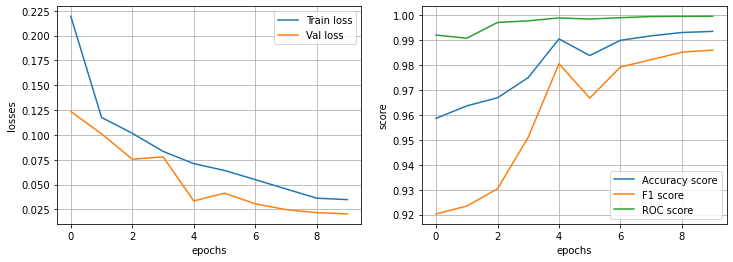

Fold 2


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.2511148942572078 Val loss = 0.1832532789025988 Val scores: acc:0.8922483766233766, f1: 0.7298262105556517, roc: 0.992392382499326, mean: 0.9098359463478064
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11824646822074383 Val loss = 0.1218829225216593 Val scores: acc:0.9572037337662337, f1: 0.9207255404420928, roc: 0.9957697899896474, mean: 0.9691911232131121
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.0989887131395879 Val loss = 0.055477637318628176 Val scores: acc:0.9797483766233765, f1: 0.9598842248694643, roc: 0.9975189284920191, mean: 0.9846608222069152
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.0784562403719391 Val loss = 0.055103776124971256 Val scores: acc:0.9794034090909092, f1: 0.9609517493390095, roc: 0.9977103760510158, mean: 0.9848665606205825
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.07519148848950863 Val loss = 0.05722866617143154 Val scores: acc:0.9817573051948051, f1: 0.9670078012525916, roc: 0.9987921379803044, mean: 0.9873248207991119
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.06060246689218368 Val loss = 0.11704435252717563 Val scores: acc:0.9536323051948051, f1: 0.8983461157748037, roc: 0.9978058624300987, mean: 0.9646618459284515
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.057530906006836434 Val loss = 0.025872122323406594 Val scores: acc:0.9931209415584416, f1: 0.987431333335534, roc: 0.9992318656227265, mean: 0.9950384819460024
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.043261131193738374 Val loss = 0.02119947716460696 Val scores: acc:0.9944602272727272, f1: 0.990298311637544, roc: 0.9990134278613874, mean: 0.9959044444400206
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.03996860143688449 Val loss = 0.0205690441752917 Val scores: acc:0.9948863636363636, f1: 0.9906071199227522, roc: 0.9994342834723371, mean: 0.9963044748116281
Epoch №: 9


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


Train loss = 0.03818742926655845 Val loss = 0.020019751810468733 Val scores: acc:0.9947849025974027, f1: 0.9905882660717501, roc: 0.9994479740379646, mean: 0.9962771110125532


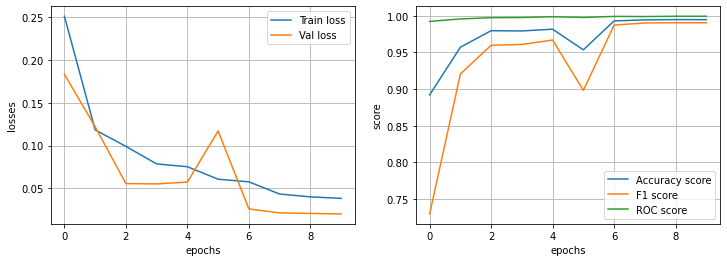

Fold 3


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.23632688335539623 Val loss = 0.1251304424234799 Val scores: acc:0.9565340909090908, f1: 0.9149473259231925, roc: 0.9891818537775766, mean: 0.964540619346154
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11042350227610347 Val loss = 0.13921589106321336 Val scores: acc:0.9415787337662337, f1: 0.874159320381938, roc: 0.9856427370174734, mean: 0.9501268527149944
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.10147682286834603 Val loss = 0.06325567588210106 Val scores: acc:0.9750202922077922, f1: 0.9495602789825063, roc: 0.9964250209084708, mean: 0.9806306539130747
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.08052194552522812 Val loss = 0.04593016941632543 Val scores: acc:0.9840503246753247, f1: 0.968359469837181, roc: 0.9985567353392639, mean: 0.9881653590396654
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.07382738887461607 Val loss = 0.20424137030329023 Val scores: acc:0.9382102272727272, f1: 0.8611245208555424, roc: 0.9924415448512928, mean: 0.949908744778573
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.059490292012228066 Val loss = 0.03410096623535667 Val scores: acc:0.9880681818181819, f1: 0.9770954121150545, roc: 0.9991458296429682, mean: 0.9914124517899497
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.05275594396293876 Val loss = 0.028899752268833772 Val scores: acc:0.9890625, f1: 0.9783711033742881, roc: 0.9990695827828331, mean: 0.9919277620662742
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.044673732044086145 Val loss = 0.019657646591908166 Val scores: acc:0.9924107142857143, f1: 0.9845424130310968, roc: 0.9997337936422815, mean: 0.9944985937130745
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.039134395438019165 Val loss = 0.017976460472813673 Val scores: acc:0.9928571428571429, f1: 0.9856194922366387, roc: 0.9997704767707546, mean: 0.9948662796898479
Epoch №: 9


100%|██████████| 209/209 [01:48<00:00,  1.92it/s]


Train loss = 0.0358111582001288 Val loss = 0.017424940071733935 Val scores: acc:0.9926339285714286, f1: 0.9852719778662818, roc: 0.999780220026763, mean: 0.9947346841580664


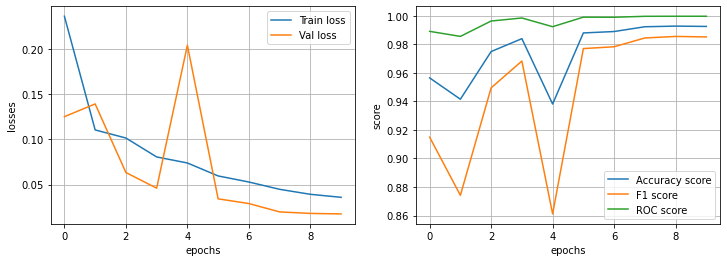

Fold 4


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.25303544187873744 Val loss = 0.12842078570808682 Val scores: acc:0.9475243506493507, f1: 0.8881392201256265, roc: 0.9893615045133229, mean: 0.9565659014765919
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11872818875327065 Val loss = 0.7679616246904646 Val scores: acc:0.7635957792207793, f1: 0.15439352125310588, roc: 0.9644431202692582, mean: 0.7421789981514839
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.09965679055730407 Val loss = 0.07079937048256398 Val scores: acc:0.9711444805194805, f1: 0.9411967681159417, roc: 0.9972468239114374, mean: 0.9782061097347509
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.08211493408351994 Val loss = 0.06915689930319786 Val scores: acc:0.9724837662337663, f1: 0.9445835506543387, roc: 0.9964912182536293, mean: 0.9789074491278122
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.07394558505899312 Val loss = 0.03856531357658761 Val scores: acc:0.9872970779220779, f1: 0.9748897366967658, roc: 0.998686859294898, mean: 0.9905105003634256
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.062735799361359 Val loss = 0.03215970653774483 Val scores: acc:0.9898538961038962, f1: 0.9803523733206246, roc: 0.9992281342246374, mean: 0.9926407106076125
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.053993737077759354 Val loss = 0.025892959614949567 Val scores: acc:0.9926339285714286, f1: 0.9850109684202337, roc: 0.9993193058338359, mean: 0.9944520251723932
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.04461511691283595 Val loss = 0.020232989076924113 Val scores: acc:0.9941964285714285, f1: 0.9883381601356868, roc: 0.9995954083354098, mean: 0.995724264766271
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.03730609829862865 Val loss = 0.018680327781476082 Val scores: acc:0.9936485389610391, f1: 0.9875706124374275, roc: 0.9996624923364734, mean: 0.995439930344034
Epoch №: 9


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


Train loss = 0.034000597945436764 Val loss = 0.01839618867130152 Val scores: acc:0.9932021103896105, f1: 0.9868518407968287, roc: 0.9996874394970016, mean: 0.9951747210247496


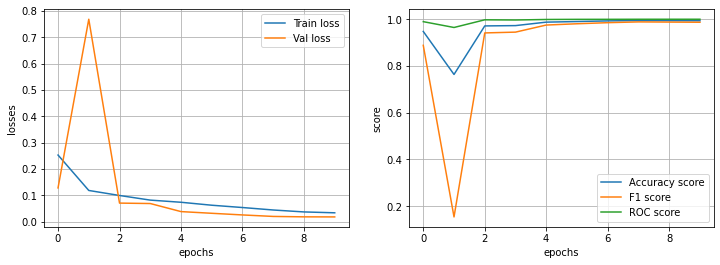

Fold 5


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.24983508569415677 Val loss = 0.1497351708156722 Val scores: acc:0.9513798701298701, f1: 0.8920600428735626, roc: 0.9890922063845737, mean: 0.9583720728059605
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11796350859141236 Val loss = 0.21897081583738326 Val scores: acc:0.927820616883117, f1: 0.8580975033428645, roc: 0.9968992305126152, mean: 0.9484153009898155
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.09902222885006068 Val loss = 0.11381890278841768 Val scores: acc:0.9480722402597402, f1: 0.8879727229491451, roc: 0.9969155208842742, mean: 0.9604739771098881
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.09246081143225494 Val loss = 0.0963811787643603 Val scores: acc:0.9614042207792207, f1: 0.9199347964764184, roc: 0.9930217434307368, mean: 0.9689190972444184
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.07584267749526855 Val loss = 0.036257967499217815 Val scores: acc:0.9899553571428571, f1: 0.9797158801554935, roc: 0.9982302867748897, mean: 0.9920449265614006
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.06724327131571096 Val loss = 0.033015038605247224 Val scores: acc:0.9916396103896105, f1: 0.9835812114301492, roc: 0.9983488558320645, mean: 0.9933825533189453
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.058582809811645147 Val loss = 0.030270279351887957 Val scores: acc:0.9912946428571429, f1: 0.9824514774361461, roc: 0.9987088061727191, mean: 0.9932330914307317
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.04638763529618391 Val loss = 0.02127031573493566 Val scores: acc:0.9936485389610391, f1: 0.9874579957822216, roc: 0.9992080633891567, mean: 0.9951901925393344
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.03967088154788936 Val loss = 0.018907477709996914 Val scores: acc:0.9948660714285714, f1: 0.989569304857394, roc: 0.9993730068913148, mean: 0.9960601858457075
Epoch №: 9


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


Train loss = 0.036270586729192276 Val loss = 0.018956594854327186 Val scores: acc:0.9948660714285714, f1: 0.9895947544470949, roc: 0.9993393893999016, mean: 0.9960484670179411


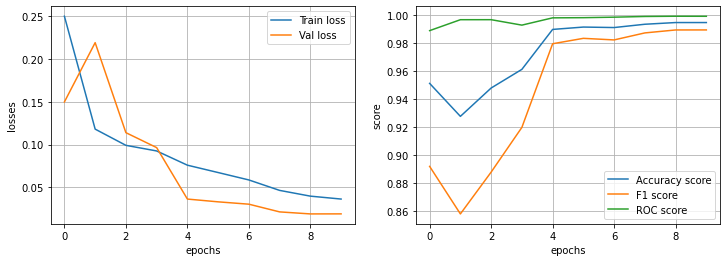

Fold 6


  0%|          | 0/209 [00:00<?, ?it/s]

Epoch №: 0


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.282356489877524 Val loss = 0.5442856953612396 Val scores: acc:0.7691761363636364, f1: 0.1628777069960491, roc: 0.9718801781273539, mean: 0.7492684713719776
Epoch №: 1


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.1371076536948601 Val loss = 0.12478398457169533 Val scores: acc:0.9420251623376623, f1: 0.8786100749387997, roc: 0.9912886821806369, mean: 0.9539739047793772
Epoch №: 2


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.11835060755245423 Val loss = 0.4977558868271964 Val scores: acc:0.8407670454545454, f1: 0.5261529471664423, roc: 0.9852367592060391, mean: 0.8500790826726717
Epoch №: 3


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.10644607875121838 Val loss = 0.06146289429494313 Val scores: acc:0.9801542207792208, f1: 0.9630108636218976, roc: 0.997769614984502, mean: 0.9855332464503967
Epoch №: 4


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.09418196609003122 Val loss = 0.06419339392866408 Val scores: acc:0.9804788961038962, f1: 0.9541743068105492, roc: 0.9985182959456668, mean: 0.984237678166112
Epoch №: 5


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.07718524907194256 Val loss = 0.03739327665950571 Val scores: acc:0.9896306818181819, f1: 0.9710383175777618, roc: 0.9995205762373433, mean: 0.9908571561796786
Epoch №: 6


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.06489081862583115 Val loss = 0.024664456842999373 Val scores: acc:0.9906655844155844, f1: 0.9810287337761455, roc: 0.9995598860498518, mean: 0.9931853651048302
Epoch №: 7


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.054745803477964476 Val loss = 0.023347148638484732 Val scores: acc:0.9916599025974027, f1: 0.9835271780322217, roc: 0.9996301841010516, mean: 0.9940184984361908
Epoch №: 8


  0%|          | 0/209 [00:00<?, ?it/s]

Train loss = 0.04737853857523731 Val loss = 0.021380154156525222 Val scores: acc:0.9924512987012987, f1: 0.984752173122211, roc: 0.9996992622558155, mean: 0.9945354553627397
Epoch №: 9


100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


Train loss = 0.04161537392956147 Val loss = 0.021844386475692902 Val scores: acc:0.99200487012987, f1: 0.9837121994506585, roc: 0.999665168363494, mean: 0.9941764851108397


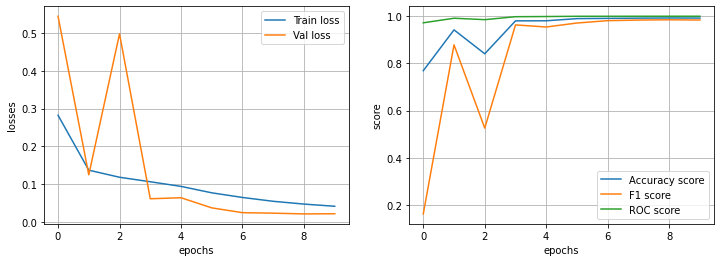

In [14]:
# # Обучение модели
# #
# n_fold = 0
# y_preds = np.zeros(1000)
# best_epochs = []

# for train_index, test_index in kfold.split(X, y):
#     print("Fold", n_fold)
#     X_train, y_train = X[train_index], y[train_index]
#     X_valid, y_valid = X[test_index], y[test_index]
    
    
#     train_data = dataset.Airplane(X_train, y_train, augmentation=augment.train_augmentation(global_var.IMAGE_SIZE))
#     val_data = dataset.Airplane(X_valid, y_valid, augmentation=augment.valid_augmentation(global_var.IMAGE_SIZE))
#     trainloader = DataLoader(train_data, batch_size=global_var.BATCH_SIZE, shuffle=False)  
#     valloader = DataLoader(val_data, batch_size=global_var.BATCH_SIZE, shuffle=False)
    
#     net = models.resnet18(pretrained=True).to(global_var.DEVICE)
#     fc_inputs = net.fc.in_features

#     net.fc = nn.Sequential(
#         nn.Linear(fc_inputs, 1)
#     ).to(global_var.DEVICE)
#     net.aux_logits = False

#     optimizer = optim.Adam(net.parameters(), lr = 0.00075)
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
#                                               max_lr=1e-3, epochs=10, steps_per_epoch=len(trainloader))

#     criterion = nn.BCEWithLogitsLoss()

#     train_losses, val_losses, accuracy, f1, roc_score, mean_score = train_model(net, global_var.DEVICE, criterion, optimizer, scheduler, trainloader, valloader, 10, global_var.DECAY, n_fold)

#     best_epochs.append(f'epoch_{np.array(mean_score).argmax()}_fold_{n_fold}.pth')

#     net.load_state_dict(torch.load(f'epoch_{np.array(accuracy).argmax()}_fold_{n_fold}.pth'))
#     y_preds += modeling.inference_fn(net, inference_dataloader, global_var.DEVICE).reshape(-1)

#     fig = plt.figure(figsize = (12,4))
#     fig.add_subplot(1,2,1)
#     plt.plot(train_losses, label = 'Train loss')
#     plt.plot(val_losses, label = 'Val loss')
#     plt.xlabel('epochs')
#     plt.ylabel('losses')
#     plt.grid()
#     plt.legend()
#     fig.add_subplot(1,2,2)
#     plt.plot(accuracy, label='Accuracy score')
#     plt.plot(f1, label='F1 score')
#     plt.plot(roc_score, label='ROC score')
#     plt.xlabel('epochs')
#     plt.ylabel('score')
#     plt.grid()
#     plt.legend()
#     plt.show()

#     n_fold+=1

In [15]:
best_epochs

['epoch_9_fold_0.pth',
 'epoch_9_fold_1.pth',
 'epoch_8_fold_2.pth',
 'epoch_8_fold_3.pth',
 'epoch_7_fold_4.pth',
 'epoch_8_fold_5.pth',
 'epoch_8_fold_6.pth']

# Making prediction first

In [18]:
# Предсказание результатов
#
n_fold = 0
y_preds_ext = np.zeros(101000)
dir_best = '7 folds current model/'
best_epochs = ['epoch_9_fold_0.pth',
 'epoch_9_fold_1.pth',
 'epoch_8_fold_2.pth',
 'epoch_8_fold_3.pth',
 'epoch_7_fold_4.pth',
 'epoch_8_fold_5.pth',
 'epoch_8_fold_6.pth']


net = models.resnet18(pretrained=True).to(global_var.DEVICE)
fc_inputs = net.fc.in_features

net.fc = nn.Sequential(
    nn.Linear(fc_inputs, 1)
).to(global_var.DEVICE)
net.aux_logits=False


for i in range(7):
    net.load_state_dict(torch.load(dir_best+best_epochs[i]))
    y_preds_ext += modeling.inference_fn(net,inference_ext_dataloader, global_var.DEVICE).reshape(-1)

In [22]:
# Сохранение результатов первой модели
#
y_blend = (y_preds_ext/7).reshape(-1)

# Making prediction second

In [23]:
# Предсказание результатов
#
n_fold = 0
y_preds_ext = np.zeros(101000)
dir_best = 'model full/'
best_epochs = ['epoch_7_fold_0.pth',
 'epoch_9_fold_1.pth',
 'epoch_8_fold_2.pth',
 'epoch_9_fold_3.pth',
 'epoch_9_fold_4.pth',
 'epoch_9_fold_5.pth',
 'epoch_9_fold_6.pth']


net = models.resnet18(pretrained=True).to(global_var.DEVICE)
fc_inputs = net.fc.in_features

net.fc = nn.Sequential(
    nn.Linear(fc_inputs, 1)
).to(global_var.DEVICE)
net.aux_logits=False


for i in range(7):
    net.load_state_dict(torch.load(dir_best+best_epochs[i]))
    y_preds_ext += modeling.inference_fn(net,inference_ext_dataloader, global_var.DEVICE).reshape(-1)

In [30]:
# Объединение результатов со второй моделью
#
y_blend = (y_preds_ext/7).reshape(-1)*0.6+y_blend*0.4

# Making prediction last

In [32]:
# Предсказание результатов
#
n_fold = 0
y_preds_ext = np.zeros(101000)
dir_best = 'mean acc and f1/'
best_epochs = ['epoch_9_fold_0.pth',
 'epoch_9_fold_1.pth',
 'epoch_9_fold_2.pth',
 'epoch_7_fold_3.pth',
 'epoch_9_fold_4.pth']


net = models.resnet18(pretrained=True).to(global_var.DEVICE)
fc_inputs = net.fc.in_features

net.fc = nn.Sequential(
    nn.Linear(fc_inputs, 1)
).to(global_var.DEVICE)
net.aux_logits=False


for i in range(5):
    net.load_state_dict(torch.load(dir_best+best_epochs[i]))
    y_preds_ext += modeling.inference_fn(net,inference_ext_dataloader, global_var.DEVICE).reshape(-1)

In [33]:
# Считывание файла примера
#
subsample = pd.read_csv('sample_submission_extended.csv')

In [55]:
# Замолнение результатов ответами моделей
#
subsample['sign'] = (y_preds_ext/5).reshape(-1)*0.8+y_blend*0.2
subsample.head()

,sign,filename
0,0.001683,68f33844-472b-4111-b600-f90d544833c7
1,0.000443,7d93a21d-1f16-49ce-8fcc-edf12c40f549
2,0.008953,4a820650-7acd-489a-ad14-9d7ad8c73b6b
3,0.999263,819b216b-2b6c-4539-a722-70648c0706c6
4,0.000146,45f7c47d-03cc-40cd-acc5-b8c1c57872fa


In [58]:
# Формирование файла с предсказаниями
#
subsample.to_csv('submission.csv', index = False)